# Replicating medical marijuana laws and opioid overdose mortality study

## Context
[Bachhuber et al. (2014)](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/1898878) found that from 1999 to 2010 states with medical marijuana laws (MML) experienced slower increases in opioid analgesic overdose mortality.

[Shover et al. (2019)](https://www.pnas.org/doi/suppl/10.1073/pnas.1903434116#executive-summary-abstract) extend Bachhuber et al.’s analysis through 2017. They find that results from the original analysis do not hold over the longer period, and the association between state MML and opioid overdose mortality reversed direction from −21% to +23% and remained positive after accounting for recreational cannabis laws.

Later, [Mathur and Ruhhm (2022)](https://www.nber.org/papers/w29802) replicate and extend upon previous studies and show that the empirical results of those studies are frequently fragile and that, in most cases, the inclusion of more comprehensive controls, longer periods and more correctly defined dependent variables results in less favorable estimates, often including predicted increases in opioid deaths.

Note: I use the term “marijuana” to refer to all types of cannabis products.

## Methods

The effects of marijuana legalization laws are estimated using differences-in-differences (DiD) models in the log-linear form:

\begin{equation}
    ln(D_{it})= \alpha + \beta_1 MML_{it}  + X_{it} \gamma + StateFE + YearFE + \varepsilon_{it}
\end{equation}

where $ln(D_{it})$ is the log of age-adjusted prescription opiod overdose death rate per 100,000 population in state $i$ in year $t$. $MML_{it}$ is an indicator for the presence of a medical marijuana law (MML) in the state and year. All years prior to a MML are coded as 0 and all years after the passage were coded as the fraction of the year in which a state has MML in effect (eg, 0.5 for a law that was implemented on July 1). $X_{it}$ is a vector with time-varying state covariates. The model includes state and year Fixed Effects (FE), and $\varepsilon_{it}$ is the regression error term. We are interested on estimate $\beta_1$.

Recall that percentage effects for these log-linear models are equal to $ \exp(\hat{\beta}) − 1 × 100 $, where $\hat{\beta}$ is the relevant policy coefficient.

## Empirical Exercise in Stata

Note: The data used in the original article is public.

### Set Stata Magic in Python

In [1]:
%%capture
import os
os.chdir('/Program Files/Stata17/utilities')
from pystata import config
config.init('se')

### Load Data 

In [2]:
%%stata
gl user "C:\Users\edloaeza\Documents\GitHub\Marijuana"
gl data "$user\data"
* Import data
qui: import delimited "$data\pnas.1903434116.sd01.csv", clear


. gl user "C:\Users\edloaeza\Documents\GitHub\Marijuana"

. gl data "$user\data"

. * Import data
. qui: import delimited "$data\pnas.1903434116.sd01.csv", clear

. 


### Create initial variables

In [3]:
%%stata
ren state state_name
qui: merge m:1 state_name using "$data\state_names_codes.dta", keepus(state_abbr state_fips) ///
    keep(match master) nogen
ren state_abbr state

* Bring dates of legalization
qui: merge 1:1 state year using "$user\Medical Marijuana Policy Data\WEB_MJ Policy.dta", ///
    keep(match master) nogen
ren state state_abbr

sort state_fips year
xtset state_fips year

* Crete year and state dummies
xi i.year*i.state_fips
drop _IyeaXsta*


. ren state state_name

. qui: merge m:1 state_name using "$data\state_names_codes.dta", keepus(state_a
> bbr state_fips) ///
>     keep(match master) nogen

. ren state_abbr state

. 
. * Bring dates of legalization
. qui: merge 1:1 state year using "$user\Medical Marijuana Policy Data\WEB_MJ P
> olicy.dta", ///
>     keep(match master) nogen

. ren state state_abbr

. 
. sort state_fips year

. xtset state_fips year

Panel variable: state_fips (unbalanced)
 Time variable: year, 1999 to 2017, but with a gap
         Delta: 1 unit

. 
. * Crete year and state dummies
. xi i.year*i.state_fips
i.year            _Iyear_1999-2017    (naturally coded; _Iyear_1999 omitted)
i.state_fips      _Istate_fip_1-56    (naturally coded; _Istate_fip_1 omitted)
i.year*i.stat~s   _IyeaXsta_#_#       (coded as above)

. drop _IyeaXsta*

. 


### Estimates for the original 1999–2010 time period

In [4]:
%%stata
eststo clear
qui: xtreg ln_age_mort_rate medical_cannabis_law unemployment *_original ///
    _Iyear_2000 - _Iyear_2010 if year<=2010, fe cl(state_fips)
est store reg1
qui: estadd local t "1999-2010", replace
qui: estadd local m "Log-linear", replace


. eststo clear

. qui: xtreg ln_age_mort_rate medical_cannabis_law unemployment *_original ///
>     _Iyear_2000 - _Iyear_2010 if year<=2010, fe cl(state_fips)

. est store reg1

. qui: estadd local t "1999-2010", replace

. qui: estadd local m "Log-linear", replace

. 


### Using the full 1999–2017 dataset

In [5]:
%%stata
eststo clear
qui: xtreg ln_age_mort_rate medical_cannabis_law unemployment *_original _Iyear*, fe cl(state_fips)
est store reg2
qui: estadd local t "1999-2017", replace
qui: estadd local m "Log-linear", replace


. eststo clear

. qui: xtreg ln_age_mort_rate medical_cannabis_law unemployment *_original _Iye
> ar*, fe cl(state_fips)

. est store reg2

. qui: estadd local t "1999-2017", replace

. qui: estadd local m "Log-linear", replace

. 


## Alternative Model

Now instead of estimating log-linear models, we use the counts of deaths as dependent variable. Similar to equation (1), we have:

\begin{equation}
    D_{it}= \alpha +\beta_1 MML_{it} + X_{it} \gamma + StateFE + YearFE + \varepsilon_{it}
\end{equation}

where $D_{it}$ is the age-adjusted opiod overdose death rate per 100,000 population in state $i$ in year $t$. We estimate Poisson regression which is often used for modeling count data.

In [6]:
%%stata
qui: poisson age_adjusted_rate medical_cannabis_law unemployment *_update _I*, vce(r)
est store reg3
qui: estadd local t "1999-2017", replace
qui: estadd local m "Poisson", replace


. qui: poisson age_adjusted_rate medical_cannabis_law unemployment *_update _I*
> , vce(r)

. est store reg3

. qui: estadd local t "1999-2017", replace

. qui: estadd local m "Poisson", replace

. 


In [7]:
%%stata
esttab reg1 reg2 reg3, label se star(* 0.10 ** 0.05 *** 0.01) ///
keep(medical_cannabis_law) ///
title("Estimates of Marijuana Legalization on Opioid Overdose Mortality") ///
stats(t N m, label("Period" "Observations" "Model" )) nonotes ///
addnotes("For (1)-(2) dependent variable is in logs." "For (3) is Age-adjusted prescription" ///
         "opioid mortality rate per 100,000 population." ///
         "Standard errors in parentheses are robust and clustered at the state-level.")


. esttab reg1 reg2 reg3, label se star(* 0.10 ** 0.05 *** 0.01) ///
> keep(medical_cannabis_law) ///
> title("Estimates of Marijuana Legalization on Opioid Overdose Mortality") ///
> stats(t N m, label("Period" "Observations" "Model" )) nonotes ///
> addnotes("For (1)-(2) dependent variable is in logs." "For (3) is Age-adjuste
> d prescription" ///
>          "opioid mortality rate per 100,000 population." ///
>          "Standard errors in parentheses are robust and clustered at the stat
> e-level.")

Estimates of Marijuana Legalization on Opioid Overdose Mortality
--------------------------------------------------------------------
                              (1)             (2)             (3)   
                     ln_age_mor~e    ln_age_mor~e    Age_Adjust~e   
--------------------------------------------------------------------
main                                                                
Medical_Cannabis_Law       -0.237**         0.205**         0.186***
            

## Event Study analysis

Now we turn to estimate event study models of the form:

\begin{equation}
    D_{it}= \alpha + \sum_{j=2}^{J}\beta_j (Lag_j)_{it} + \sum_{k=1}^{K}\lambda_k (Lead_k)_{it} + X_{it} \gamma + StateFE + YearFE + \varepsilon_{it}
\end{equation}

where lags and leads are dummy variables indicating that the given state was a given number of periods away from the event of interest in the respective time period. $J$ and $K$ lags and leads are included respectively, and, final lags and leads “accumulate” lags or leads beyond $J$ and $K$ periods.For this replication exercise we set $J$ and $K$ equal to 8. We omit the first lag ($j=1$) to capture the baseline difference between states where the event does and does not occur.

See [Clarke and Tapia (2020)](https://docs.iza.org/dp13524.pdf) on how to implement a Panel Event Study in Stata.


In [8]:
%%stata
gen timeToTreat = year - year(date_effMML)
sum timeToTreat if year<=2010


. gen timeToTreat = year - year(date_effMML)
(361 missing values generated)

. sum timeToTreat if year<=2010

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
 timeToTreat |        372   -4.209677    7.929209        -19         14

. 



. set scheme plotplain

. eventdd ln_age_mort_rate unemployment *_original i.year if year<=2010, fe ///
> timevar(timeToTreat) ci(rcap) cluster(state_fips) accum leads(8) lags(8) ///
> graph_op(ytitle("Point Estimate and 95% Confidence Interval") xlabel(-8(2)8))

Fixed-effects (within) regression               Number of obs      =       575
Group variable: state_fips                      Number of groups   =        50

R-sq:  Within  = 0.7630                         Obs per group: min =         5
       Between = 0.0098                                        avg =      11.5
       Overall = 0.3509                                        max =        12

                                                F(31,49)           =     40.69
corr(u_i, Xb)  = -0.1219                        Prob > F           =    0.0000

                            (Std. err. adjusted for 50 clusters in state_fips)
------------------------------------------------------------------------------
             |       

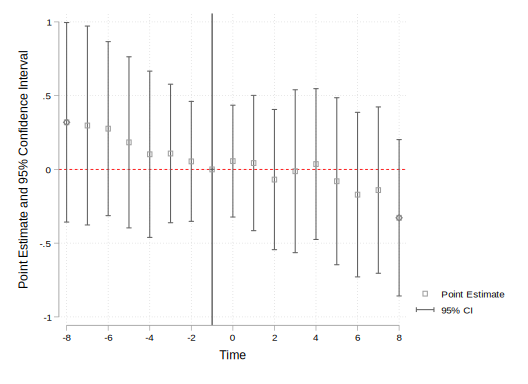

In [9]:
%%stata
set scheme plotplain
eventdd ln_age_mort_rate unemployment *_original i.year if year<=2010, fe ///
timevar(timeToTreat) ci(rcap) cluster(state_fips) accum leads(8) lags(8) ///
graph_op(ytitle("Point Estimate and 95% Confidence Interval") xlabel(-8(2)8))


. eventdd ln_age_mort_rate unemployment *_update i.year, fe ///
> timevar(timeToTreat) ci(rcap) cluster(state_fips) accum leads(8) lags(8) ///
> graph_op(ytitle("Point Estimate and 95% Confidence Interval") xlabel(-8(1)8))

Fixed-effects (within) regression               Number of obs      =       908
Group variable: state_fips                      Number of groups   =        50

R-sq:  Within  = 0.7322                         Obs per group: min =         9
       Between = 0.0042                                        avg =      18.2
       Overall = 0.4736                                        max =        19

                                                F(38,49)           =     38.35
corr(u_i, Xb)  = -0.0312                        Prob > F           =    0.0000

                            (Std. err. adjusted for 50 clusters in state_fips)
------------------------------------------------------------------------------
             |               Robust
ln_age_mor~e | Coefficien

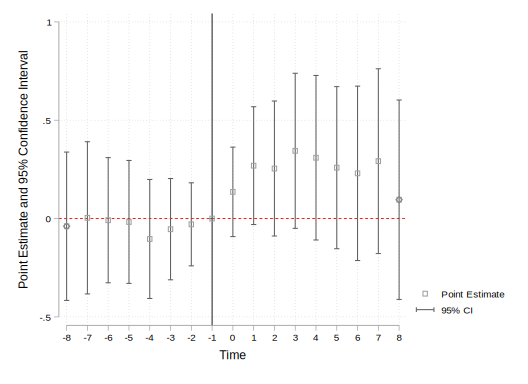

In [10]:
%%stata
eventdd ln_age_mort_rate unemployment *_update i.year, fe ///
timevar(timeToTreat) ci(rcap) cluster(state_fips) accum leads(8) lags(8) ///
graph_op(ytitle("Point Estimate and 95% Confidence Interval") xlabel(-8(1)8))